In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import cv2

In [3]:
!ls

'My Drive'


In [0]:
def abrir_imagem(img_caminho):
    """
        img_caminho: caminho completo para a imagem
    """
    imagem = cv2.imread(img_caminho, cv2.IMREAD_GRAYSCALE)

    if imagem is None:
        raise NameError("O OpenCV não conseguiu abrir sua imagem. Verique o caminho.")

    return imagem

In [0]:
caminho_absoluto = lambda img_nome:"My Drive/Curso-OMR/images-test/"+img_nome
nome_imagem = "teste0.png"
imagem = abrir_imagem(caminho_absoluto(nome_imagem))

In [0]:
_, imagem_binaria = cv2.threshold(imagem, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

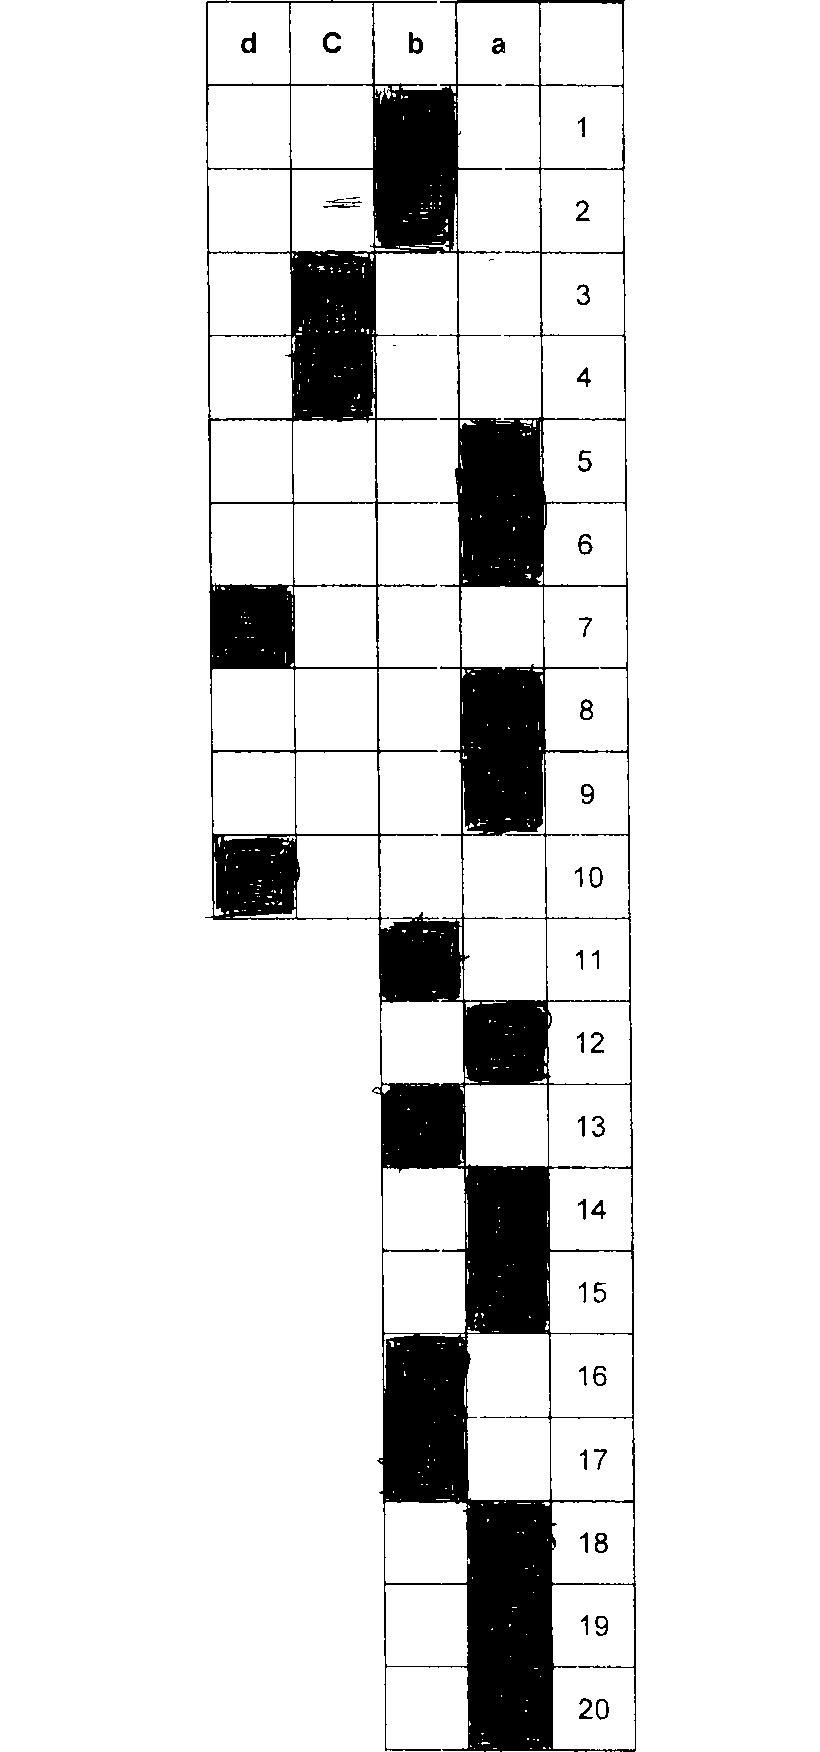

In [45]:
from google.colab.patches import cv2_imshow

cv2_imshow(imagem_binaria)

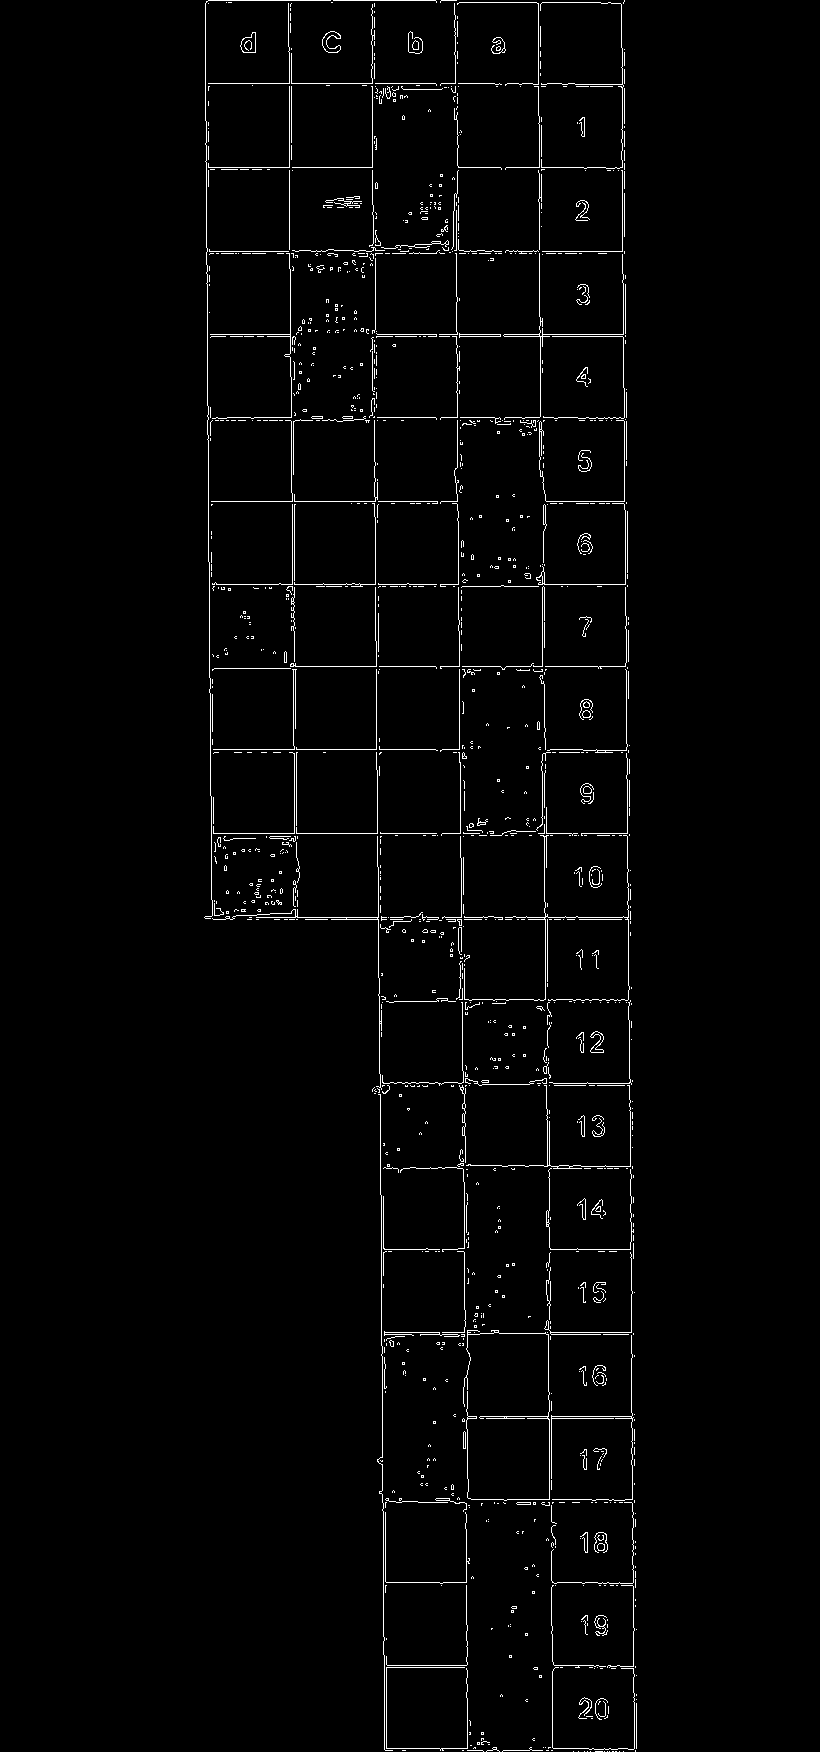

In [46]:
img_canny = cv2.Canny(imagem_binaria, 100, 200)
cv2_imshow(img_canny)

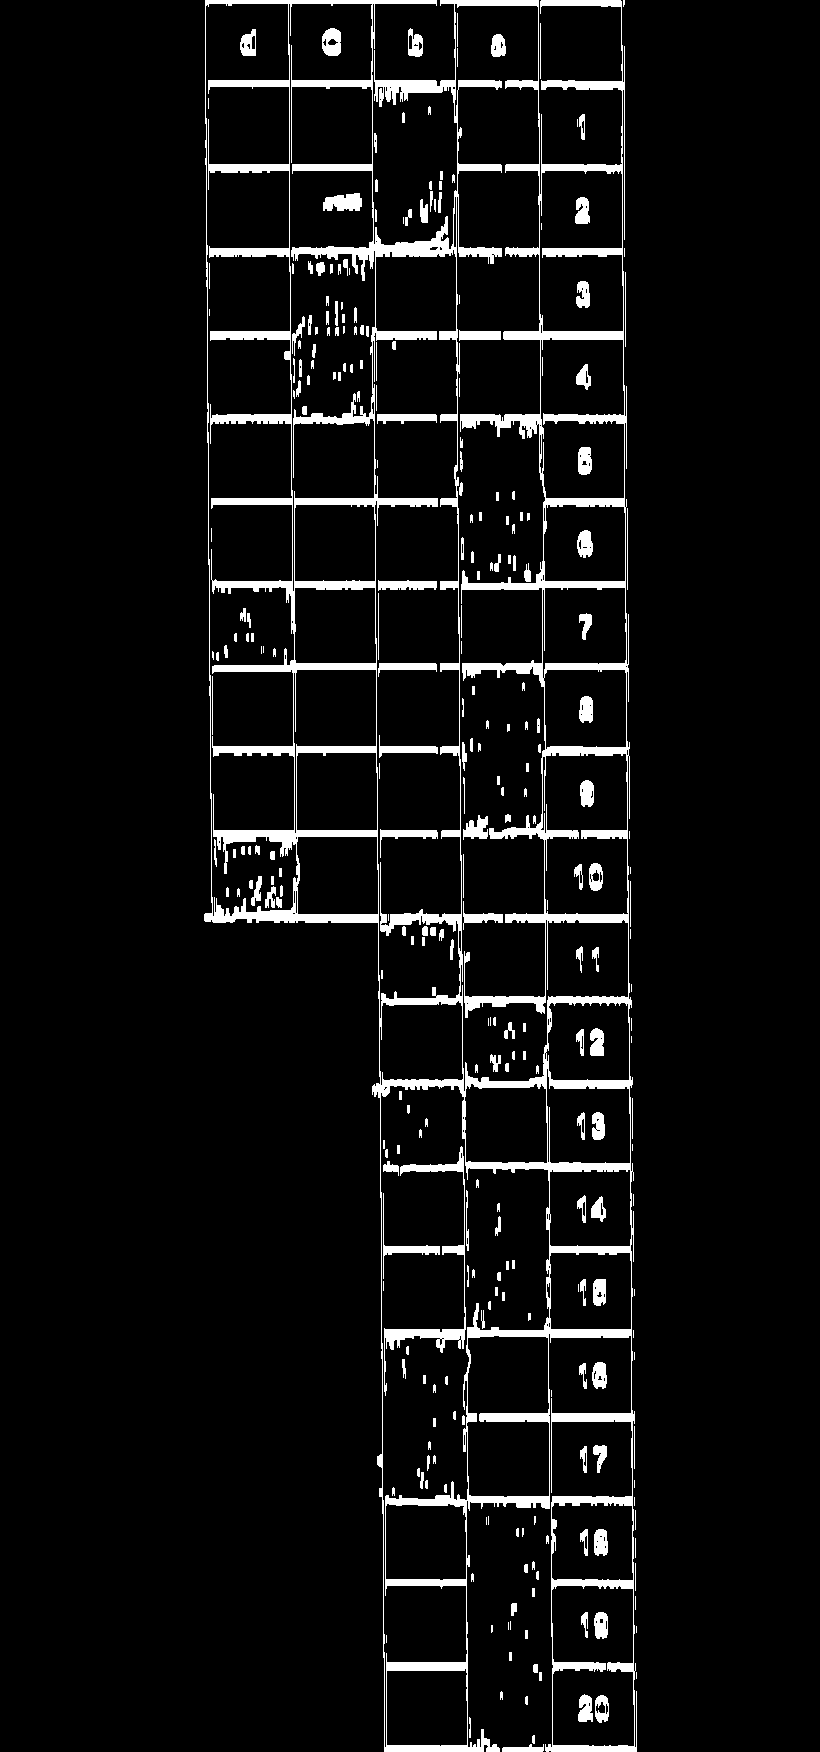

In [47]:
kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (1,3))
operacao_dilatar = cv2.morphologyEx(img_canny, cv2.MORPH_DILATE, kernel_rect, iterations=3)

cv2_imshow(operacao_dilatar)

#print(kernel_rect)

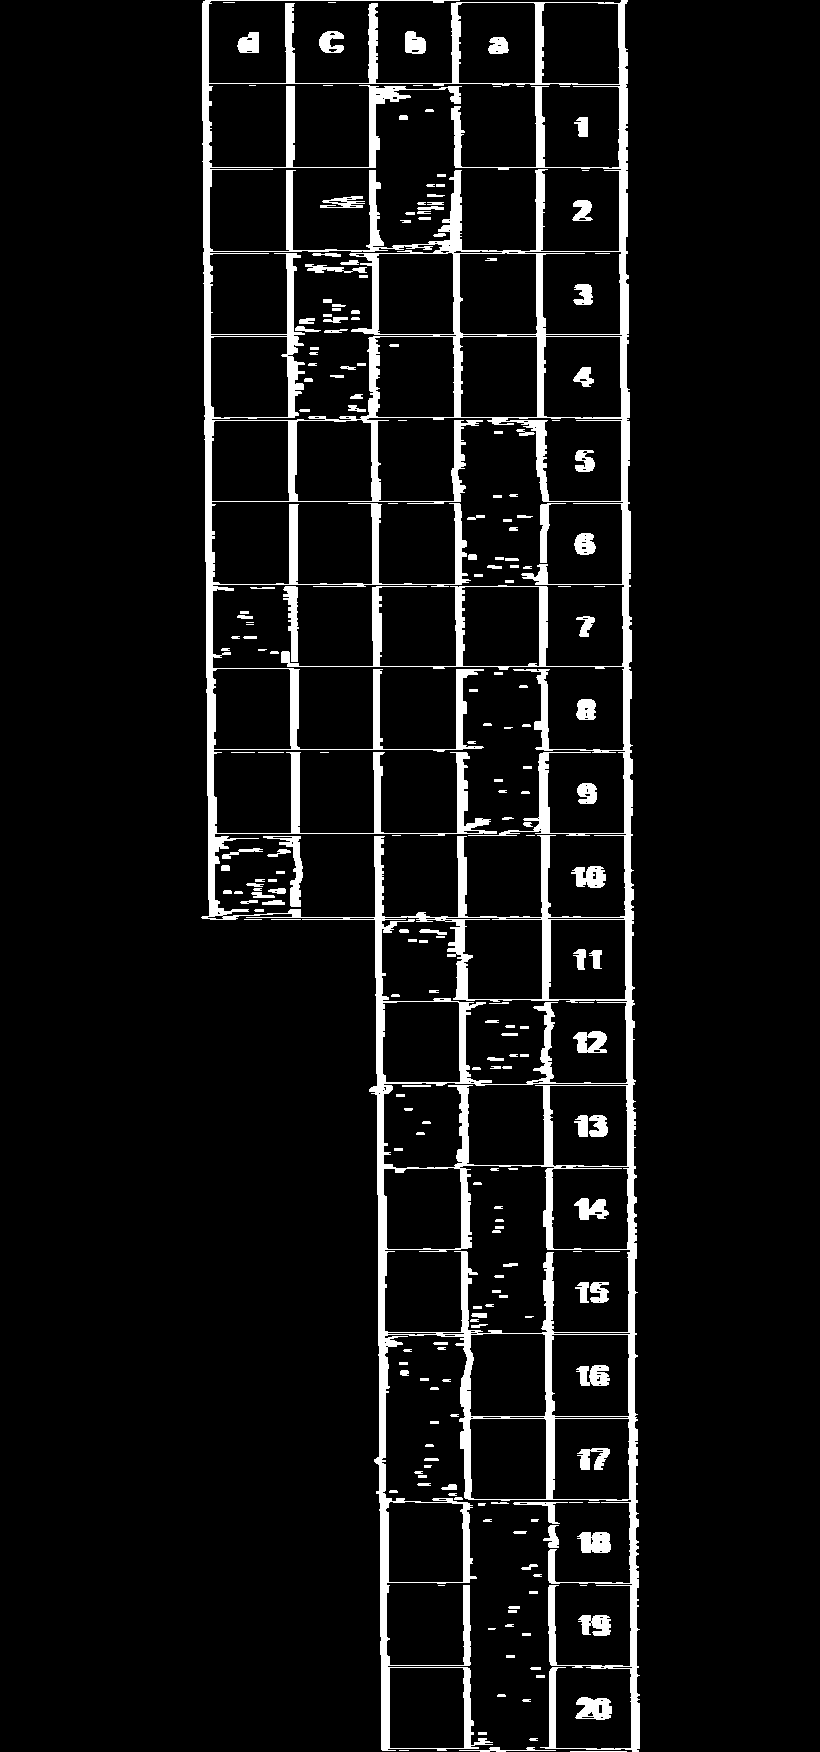

In [48]:
kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1))
operacao_vertical = cv2.morphologyEx(img_canny, cv2.MORPH_DILATE, kernel_vertical, iterations=3)
cv2_imshow(operacao_vertical)

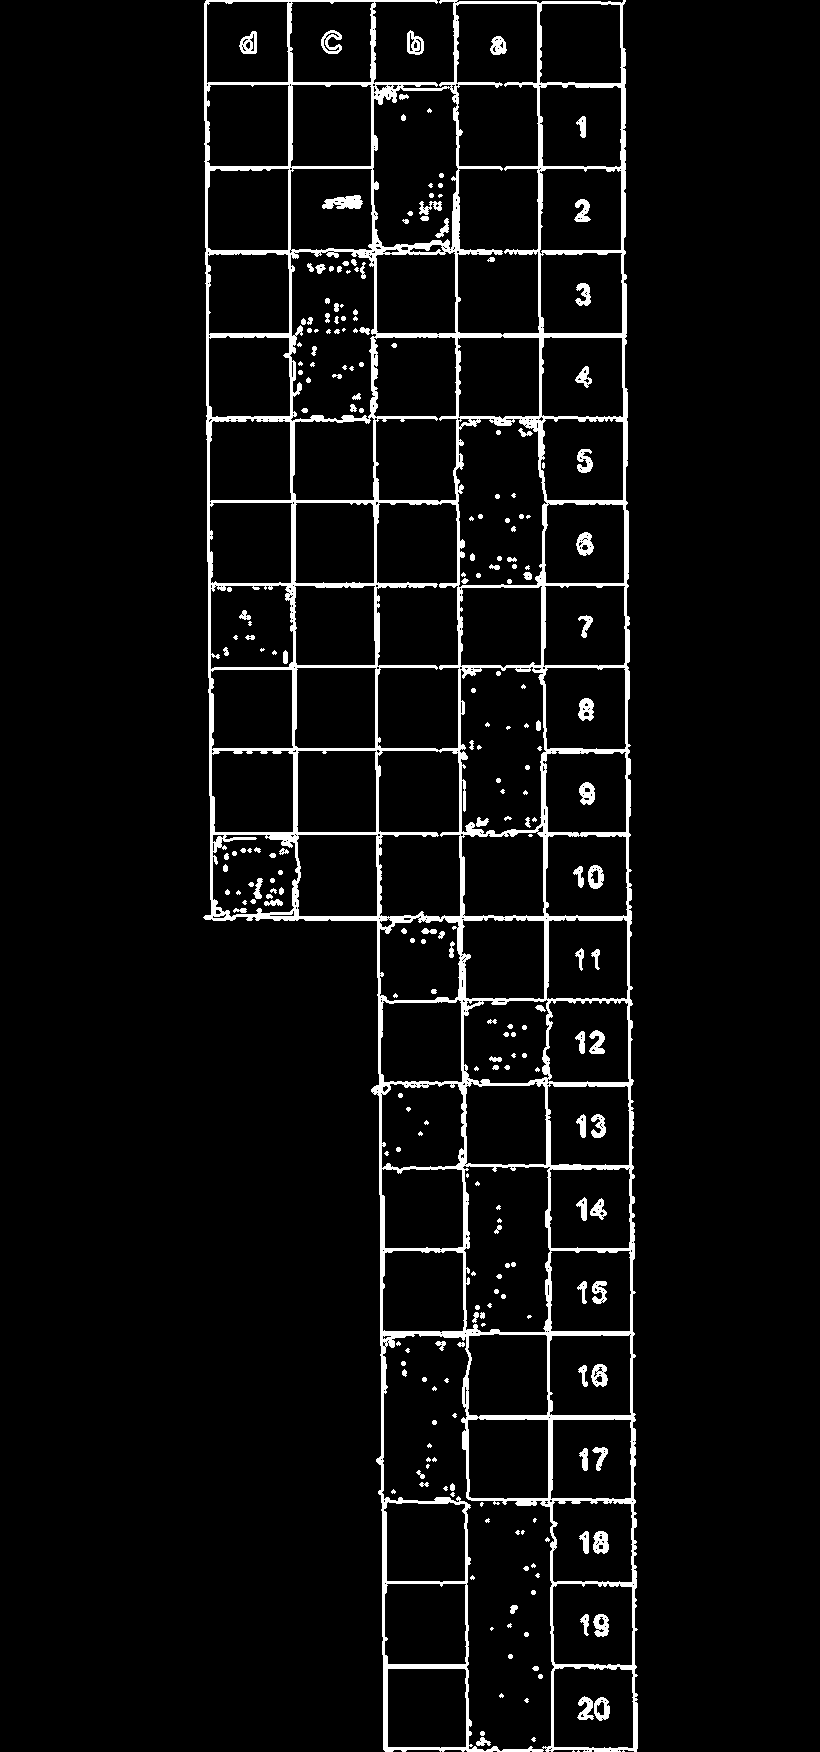

In [50]:
kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
operacao_cross = cv2.morphologyEx(img_canny, cv2.MORPH_DILATE, kernel_cross)
cv2_imshow(operacao_cross)